<h1 style="text-align: center">Happiness Prediction</h1>

In [300]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

In [301]:
df = pd.read_csv('Somerville_happiness.csv', sep=',', header=0)
df = df[df.year == 2021] # Only data from 2011 
df.head()
df[['Annual household income', 'Housing satisfaction']]


,Annual household income,Housing satisfaction
9251,124999.500000,10.0
9252,87499.500000,9.0
9253,87499.500000,6.0
9254,62499.500000,3.0
9255,62499.500000,8.0
...,...,...
10511,62499.500000,9.0
10512,174999.500000,9.0
10513,174999.500000,10.0
10514,210000.000000,8.0


In [302]:
# prior_predictive_dist = CmdStanModel(stan_file='model1_ppc.stan')

# # Compilation of code_1.stan and get 1000 samples
# samples = prior_predictive_dist.sample(fixed_param=True, 
#                                        iter_sampling=1000)

# # Creation of pandas dataframe from resulting draws
# df = samples.draws_pd()
# display(df)

# # Compute ratio of allergic reactions for each sample
# ratio = df['y'] / df['N']

predictors = df[['Annual household income', 'Housing satisfaction']].head(100).to_numpy()
print(df['Housing satisfaction'].unique())
print(predictors)
predictors = predictors/predictors.max(axis=0)
# predictors = predictors-predictors.mean(axis=0)
target = df['Life satisfaction'].head(100).to_numpy().astype('int')
print(target)
print(predictors)
xd = CmdStanModel(stan_file='test.stan')

d = {'K' : 10,
     'N' : 100,
     'J' : 2,
     'y' : target,
     'X' : predictors}

# Compilation of code_1.stan and get 1000 samples
samples = xd.sample(data=d, fixed_param=True, iter_sampling=1000, iter_warmup=1000, chains=1)
print(samples.diagnose())

# Creation of pandas dataframe from resulting draws
df_old = samples.draws_pd()
display(df_old)

# Compute ratio of allergic reactions for each sample
# ratio = df['y'] / df['N']

[10.          9.          6.          3.          8.          7.
  5.          1.          7.59418128  4.          2.        ]
[[1.24999500e+05 1.00000000e+01]
 [8.74995000e+04 9.00000000e+00]
 [8.74995000e+04 6.00000000e+00]
 [6.24995000e+04 3.00000000e+00]
 [6.24995000e+04 8.00000000e+00]
 [1.24999500e+05 7.00000000e+00]
 [1.24999500e+05 5.00000000e+00]
 [1.74999500e+05 8.00000000e+00]
 [6.24995000e+04 9.00000000e+00]
 [2.10000000e+05 8.00000000e+00]
 [6.24995000e+04 1.00000000e+01]
 [6.24995000e+04 1.00000000e+00]
 [1.24999500e+05 1.00000000e+01]
 [8.40787120e+04 7.00000000e+00]
 [5.00000000e+03 7.00000000e+00]
 [8.74995000e+04 1.00000000e+01]
 [3.74995000e+04 1.00000000e+01]
 [2.10000000e+05 9.00000000e+00]
 [8.74995000e+04 7.59418128e+00]
 [1.24999500e+05 6.00000000e+00]
 [2.10000000e+05 9.00000000e+00]
 [1.24999500e+05 8.00000000e+00]
 [2.10000000e+05 1.00000000e+01]
 [1.24999500e+05 7.59418128e+00]
 [3.74995000e+04 1.00000000e+01]
 [6.24995000e+04 8.00000000e+00]
 [1.24999500e+0

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.



Processing csv files: /tmp/tmpqrs8zwpn/test-20230708155608.csvWarning: non-fatal error reading adaptation data


Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



,lp__,accept_stat__,c[1],c[2],c[3],c[4],c[5],c[6],c[7],c[8],...,happy[91],happy[92],happy[93],happy[94],happy[95],happy[96],happy[97],happy[98],happy[99],happy[100]
0,0.0,0.0,0.313932,0.48359,1.10094,1.48535,1.80479,4.82456,5.04236,5.21062,...,1.0,4.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,4.0
1,0.0,0.0,0.313932,0.48359,1.10094,1.48535,1.80479,4.82456,5.04236,5.21062,...,6.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.313932,0.48359,1.10094,1.48535,1.80479,4.82456,5.04236,5.21062,...,1.0,6.0,6.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0
3,0.0,0.0,0.313932,0.48359,1.10094,1.48535,1.80479,4.82456,5.04236,5.21062,...,1.0,1.0,1.0,3.0,1.0,1.0,4.0,1.0,6.0,1.0
4,0.0,0.0,0.313932,0.48359,1.10094,1.48535,1.80479,4.82456,5.04236,5.21062,...,3.0,1.0,6.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.313932,0.48359,1.10094,1.48535,1.80479,4.82456,5.04236,5.21062,...,3.0,1.0,6.0,3.0,6.0,1.0,1.0,6.0,1.0,1.0
996,0.0,0.0,0.313932,0.48359,1.10094,1.48535,1.80479,4.82456,5.04236,5.21062,...,6.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,1.0,1.0
997,0.0,0.0,0.313932,0.48359,1.10094,1.48535,1.80479,4.82456,5.04236,5.21062,...,1.0,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
998,0.0,0.0,0.313932,0.48359,1.10094,1.48535,1.80479,4.82456,5.04236,5.21062,...,1.0,6.0,3.0,6.0,3.0,1.0,1.0,1.0,6.0,6.0


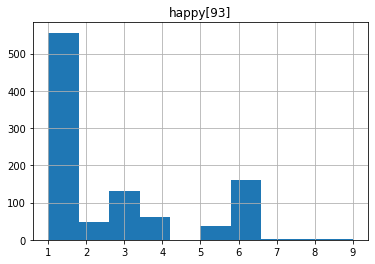

In [303]:

df_old.hist(column='happy[93]')
plt.show()
# plt.figure()
# plt.hist()
# plt.show()

In [304]:


# predictors = predictors/predictors.max(axis=0)
# predictors = predictors-predictors.mean(axis=0)
target = df['Life satisfaction'].head(100).to_numpy().astype('int')


xd = CmdStanModel(stan_file='test2.stan')

income = df['Annual household income'].head(100).to_numpy().astype('int')
income = (income/income.std(axis=0))
income = income-income.mean(axis=0)

print(income)
d = {'N' : 100,
     'K' : 10,
     'y' : target,
     'income' : income,
     'satisfaction' : df['Housing satisfaction'].head(100).to_numpy().astype('int'),
     'child' : df['Living with children under 18'].head(100).to_numpy().astype('int')}

# Compilation of code_1.stan and get 1000 samples
samples = xd.sample(data=d, fixed_param=True, iter_sampling=1000, iter_warmup=1000, chains=1)
print(samples.diagnose())

# Creation of pandas dataframe from resulting draws
df_res = samples.draws_pd()
display(df_res)

# Compute ratio of allergic reactions for each sample
# ratio = df['y'] / df['N']

INFO:cmdstanpy:compiling stan file /home/Final project/test2.stan to exe file /home/Final project/test2
INFO:cmdstanpy:compiled model executable: /home/Final project/test2
--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmpm7vczlsg/tmpz6qtai3d.hpp /tmp/tmpm7vczlsg/tmpz6qtai3d.stan
Warning in '/tmp/tmpm7vczlsg/tmpz6qtai3d.stan', line 6, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/tmpm7vczlsg/tmpz6qtai3d.stan', line 9, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/tmpm7vczlsg/tmpz6qtai3d.stan', line 12, column 2: Declaratio

[ 0.23761586 -0.40423158 -0.40423158 -0.83212986 -0.83212986  0.23761586
  0.23761586  1.09341243 -0.83212986  1.69248715 -0.83212986 -0.83212986
  0.23761586 -0.46278518 -1.81627881 -0.40423158 -1.26002815  1.69248715
 -0.40423158  0.23761586  1.69248715  0.23761586  1.69248715  0.23761586
 -1.26002815 -0.83212986  0.23761586 -0.83212986 -0.46278518 -0.46278518
  1.09341243 -1.26002815 -0.46278518  0.23761586 -1.60234678 -1.81627881
  0.23761586 -0.83212986  1.09341243 -0.83212986  0.23761586  0.23761586
  0.23761586  1.09341243 -0.40423158 -1.26002815 -1.26002815  1.69248715
 -1.26002815  1.69248715 -0.46278518  1.09341243  1.09341243 -0.83212986
  1.09341243  0.23761586  0.23761586 -1.26002815 -0.46278518  1.09341243
  1.09341243  1.69248715 -1.26002815 -1.26002815 -0.83212986 -0.83212986
 -0.46278518  0.23761586 -0.83212986 -0.83212986  0.23761586  1.09341243
 -0.40423158  1.69248715 -0.46278518  1.09341243 -1.60234678  0.23761586
  0.23761586  0.23761586  0.23761586 -0.83212986  0

chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.



Processing csv files: /tmp/tmpqrs8zwpn/test2-20230708155626.csvWarning: non-fatal error reading adaptation data


Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



,lp__,accept_stat__,c[1],c[2],c[3],c[4],c[5],c[6],c[7],c[8],...,happy[91],happy[92],happy[93],happy[94],happy[95],happy[96],happy[97],happy[98],happy[99],happy[100]
0,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,...,7.0,7.0,5.0,7.0,5.0,7.0,4.0,7.0,7.0,7.0
1,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,...,7.0,7.0,7.0,7.0,4.0,7.0,5.0,7.0,5.0,7.0
2,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,...,7.0,7.0,5.0,7.0,4.0,7.0,4.0,7.0,5.0,8.0
3,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,...,7.0,7.0,7.0,7.0,4.0,7.0,4.0,7.0,5.0,7.0
4,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,...,8.0,7.0,7.0,5.0,4.0,7.0,5.0,7.0,8.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,...,7.0,7.0,7.0,7.0,4.0,7.0,5.0,7.0,7.0,6.0
996,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,...,7.0,7.0,5.0,7.0,5.0,7.0,4.0,7.0,7.0,7.0
997,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,...,7.0,7.0,7.0,8.0,5.0,7.0,5.0,8.0,7.0,7.0
998,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,...,7.0,7.0,7.0,5.0,4.0,7.0,4.0,7.0,5.0,5.0


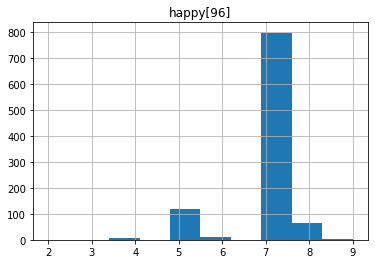

,lp__,accept_stat__,c[1],c[2],c[3],c[4],c[5],c[6],c[7],c[8],c[9],beta_income,beta_satisfy[1],beta_satisfy[2],beta_satisfy[3],beta_satisfy[4],beta_satisfy[5],beta_satisfy[6],beta_satisfy[7],beta_satisfy[8],beta_satisfy[9],beta_satisfy[10],beta_child,happy[1],happy[2],happy[3],happy[4],happy[5],happy[6],happy[7],happy[8],happy[9],happy[10],happy[11],happy[12],happy[13],happy[14],happy[15],happy[16],happy[17],happy[18],happy[19],happy[20],happy[21],happy[22],happy[23],happy[24],happy[25],happy[26],happy[27],happy[28],happy[29],happy[30],happy[31],happy[32],happy[33],happy[34],happy[35],happy[36],happy[37],happy[38],happy[39],happy[40],happy[41],happy[42],happy[43],happy[44],happy[45],happy[46],happy[47],happy[48],happy[49],happy[50],happy[51],happy[52],happy[53],happy[54],happy[55],happy[56],happy[57],happy[58],happy[59],happy[60],happy[61],happy[62],happy[63],happy[64],happy[65],happy[66],happy[67],happy[68],happy[69],happy[70],happy[71],happy[72],happy[73],happy[74],happy[75],happy[76],happy[77],happy[78],happy[79],happy[80],happy[81],happy[82],happy[83],happy[84],happy[85],happy[86],happy[87],happy[88],happy[89],happy[90],happy[91],happy[92],happy[93],happy[94],happy[95],happy[96],happy[97],happy[98],happy[99],happy[100]
0,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,18.6045,0.037638,1.43026,5.70915,6.119,6.92272,9.82346,10.0492,10.6029,10.9772,11.115,11.3412,-0.460476,7.0,7.0,7.0,5.0,7.0,5.0,7.0,7.0,7.0,8.0,7.0,1.0,7.0,7.0,7.0,7.0,7.0,9.0,7.0,7.0,8.0,7.0,5.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0,7.0,4.0,1.0,7.0,7.0,5.0,5.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0,7.0,4.0,5.0,7.0,5.0,7.0,8.0,7.0,5.0,1.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,5.0,7.0,5.0,7.0,4.0,7.0,7.0,7.0
1,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,18.6045,0.037638,1.43026,5.70915,6.119,6.92272,9.82346,10.0492,10.6029,10.9772,11.115,11.3412,-0.460476,7.0,7.0,7.0,4.0,7.0,7.0,7.0,7.0,7.0,8.0,7.0,4.0,7.0,5.0,7.0,7.0,7.0,8.0,4.0,5.0,7.0,7.0,7.0,5.0,7.0,8.0,5.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,5.0,4.0,7.0,7.0,7.0,8.0,7.0,4.0,7.0,7.0,7.0,5.0,8.0,5.0,5.0,7.0,8.0,7.0,7.0,7.0,7.0,5.0,7.0,6.0,4.0,5.0,5.0,7.0,7.0,8.0,5.0,7.0,7.0,6.0,7.0,7.0,7.0,7.0,4.0,7.0,5.0,7.0,7.0,5.0,7.0,7.0,8.0,7.0,7.0,7.0,7.0,4.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,4.0,7.0,5.0,7.0,5.0,7.0
2,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,18.6045,0.037638,1.43026,5.70915,6.119,6.92272,9.82346,10.0492,10.6029,10.9772,11.115,11.3412,-0.460476,7.0,7.0,5.0,4.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,4.0,7.0,7.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0,8.0,5.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,8.0,5.0,4.0,7.0,7.0,7.0,8.0,7.0,1.0,7.0,5.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,7.0,4.0,5.0,7.0,5.0,7.0,7.0,7.0,8.0,3.0,7.0,7.0,7.0,5.0,8.0,7.0,8.0,7.0,7.0,5.0,7.0,4.0,5.0,7.0,7.0,7.0,7.0,7.0,7.0,5.0,7.0,4.0,7.0,4.0,7.0,5.0,8.0
3,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,18.6045,0.037638,1.43026,5.70915,6.119,6.92272,9.82346,10.0492,10.6029,10.9772,11.115,11.3412,-0.460476,5.0,7.0,7.0,4.0,7.0,7.0,5.0,5.0,7.0,5.0,7.0,4.0,7.0,5.0,7.0,5.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,4.0,7.0,7.0,7.0,7.0,5.0,4.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,5.0,6.0,8.0,7.0,7.0,5.0,4.0,7.0,7.0,5.0,7.0,7.0,7.0,7.0,4.0,7.0,7.0,7.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0,7.0,5.0,7.0,5.0,5.0,7.0,7.0,7.0,7.0,7.0,7.0,4.0,7.0,4.0,7.0,5.0,7.0
4,0.0,0.0,-0.986994,0.082768,0.880818,6.52894,9.03729,9.17687,13.6541,16.8287,18.6045,0.037638,1.43026,5.70915,6.119,6.92272,9.82346,10.0492,10.6029,10.9772,11.115,11.3412,-0.460476,7.0,7.0,7.0,5.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,2.0,5.0,7.0,8.0,7.0,7.0,7.0,6.0,7.0,8.0,5.0,8.0,7.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0,5.0,7.0,4.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,5.0,8.0,7.0,5.0,7.0,5.0,4.0,7.0,7

In [306]:
# for col in df_res.columns:
#     print(col)
df_res.hist(column='happy[96]')
plt.show()

pd.set_option('display.max_columns', None) 

# pd.set_option("display.max_rows", None)
display(df_res)
# print(df_res.columns)